# EasyOCR Text Detection

In [ ]:
!pip3 install torch torchvision torchaudio > /dev/null
!pip install easyocr > /dev/null

In [ ]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [ ]:
IMAGE_PATH = '/content/16b444db1623896ebafb4a75555981ba.jpg'

In [ ]:
reader = easyocr.Reader(['ko'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [ ]:
result = reader.readtext(IMAGE_PATH)
result

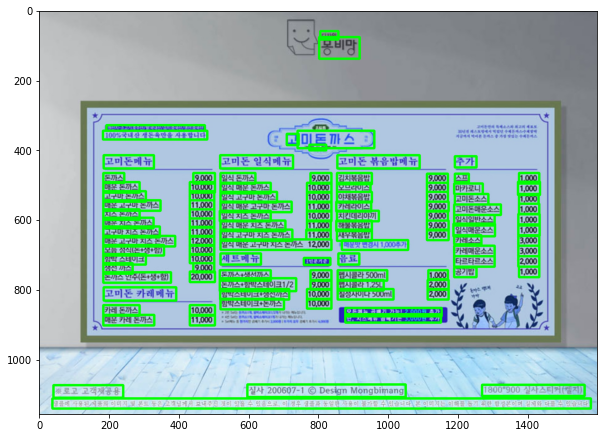

In [ ]:
img = cv2.imread(IMAGE_PATH)
crop_img = []
for detection in result:
  top_left = tuple([int(val) for val in detection[0][0]])
  bottom_right = tuple([int(val) for val in detection[0][2]])
  text = detection[1]
  font = cv2.FONT_HERSHEY_SIMPLEX
  img = cv2.rectangle(img, top_left, bottom_right, (0,255,0), 5)
  crop_img.append([top_left,bottom_right])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [ ]:
crop_img

# Bounding Box 기준으로 Image Crop하기

In [ ]:
# 폴더만들기
!mkdir /content/crop_image/
from PIL import Image


for i in range(len(crop_img)):
  # 바운딩 8개 좌표
  # top_left = crop_img[i][0]
  # top_right = (crop_img[i][1][0],crop_img[i][0][1])
  # bottom_left = (crop_img[i][0][0],crop_img[i][1][1])
  # bottom_right = crop_img[i][1]
  # print(top_left,top_right,bottom_left,bottom_right)

  # 필요한 값
  # crop(left,up, rigth, down)
  # print(crop_img[i][0][0],crop_img[i][0][1],crop_img[i][1][0],crop_img[i][1][1])
  img = Image.open(IMAGE_PATH)

  croppedImage=img.crop((crop_img[i][0][0],crop_img[i][0][1],crop_img[i][1][0],crop_img[i][1][1]))
  if crop_img[i][0][0] >= crop_img[i][1][0] or crop_img[i][0][1] >= crop_img[i][1][1]:
    continue
  croppedImage.save(f'/content/crop_image/cropped{i}.PNG')

mkdir: cannot create directory ‘/content/crop_image/’: File exists


# Super Resolution github 가져오기

In [ ]:
# Real-ESRGAN 라이브러리
%cd /content
!git clone https://github.com/xinntao/Real-ESRGAN.git 
%cd Real-ESRGAN 
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# BSRGAN 라이브러리
!git clone https://github.com/cszn/BSRGAN.git

# SwinIR 라이브러리
!rm -r SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# 2배 pre-trined model 가져오기
# !wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGANx2.pth -P BSRGAN/model_zoo
# !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth -P experiments/pretrained_models
# !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x2_GAN.pth -P experiments/pretrained_models

# 4배 가져오기
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

/content
fatal: destination path 'Real-ESRGAN' already exists and is not an empty directory.
/content/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running develop
running egg_info
writing realesrgan.egg-info/PKG-INFO
writing dependency_links to realesrgan.egg-info/dependency_links.txt
writing requirements to realesrgan.egg-info/requires.txt
writing top-level names to realesrgan.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'realesrgan.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/realesrgan.egg-link (link to .)
realesrga

In [ ]:
%cd /content/Real-ESRGAN

/content/Real-ESRGAN


In [ ]:
import os
import glob
from google.colab import files
import shutil

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet' # crop 된 이미지 저장된 공간
result_folder = 'results' # 결과 저장될 폴더

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

path = '/content/crop_image' # 크롭된 이미지 있는 경로
for filename in os.listdir(path):
  dst_path = os.path.join(upload_folder,filename)
  filename = path +'/'+filename
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path) # crop된 이미지 데이터 이동

In [ ]:
# SwinIR-Large
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) 

# 모든파일 Resolution 적용코드

In [ ]:
path = '/content/Real-ESRGAN/results/SwinIR_large'
file_list = os.listdir(path)
file_list

['cropped12_SwinIR_large.png',
 'cropped10_SwinIR_large.png',
 'cropped5_SwinIR_large.png',
 'cropped15_SwinIR_large.png',
 'cropped20_SwinIR_large.png',
 'cropped3_SwinIR_large.png',
 'cropped2_SwinIR_large.png',
 'cropped13_SwinIR_large.png',
 'cropped18_SwinIR_large.png',
 'cropped11_SwinIR_large.png',
 'cropped14_SwinIR_large.png',
 'cropped17_SwinIR_large.png',
 'cropped9_SwinIR_large.png',
 'cropped7_SwinIR_large.png',
 'cropped8_SwinIR_large.png',
 'cropped4_SwinIR_large.png',
 'cropped6_SwinIR_large.png',
 'cropped16_SwinIR_large.png',
 'cropped1_SwinIR_large.png',
 'cropped0_SwinIR_large.png']

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow
# for f in file_list:
#   img = cv2.imread(path+'/'+f)
#   res = cv2.resize(img,(200,64),interpolation=cv2.INTER_LINEAR)
#   cv2.imwrite(path+'/'+f, res)
#   cv2_imshow(res)

# Text Recognition

In [ ]:
%cd /content/
!git clone https://github.com/clovaai/deep-text-recognition-benchmark

/content
Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (301/301), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/OCR/OCR/TPS-ResNet-BiLSTM-CTC-Seed1111/OrgandAug/100000it/best_norm_ED.pth','/content/best_norm_ED.pth')

'/content/best_norm_ED.pth'

In [ ]:
%cd /content/deep-text-recognition-benchmark

/content/deep-text-recognition-benchmark


In [ ]:
# demo 파일 변경해야됨
!CUDA_VISIBLE_DEVICES=0 python3 demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
--image_folder /content/Real-ESRGAN/results/SwinIR_large --imgH 64 --imgW 200 \
--saved_model /content/best_norm_ED.pth

model input parameters 64 200 20 1 512 256 1011 25 TPS ResNet BiLSTM CTC
loading pretrained model from /content/best_norm_ED.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
--------------------------------------------------------------------------------
image_path               	ground_truth   	predicted_labels	confidence score
--------------------------------------------------------------------------------
/content/Real-ESRGAN/results/SwinIR_large/cropped0_SwinIR_large.png	cropped0_SwinIR_large	디자안            	F | 0.5949
/content/Real-ESRGAN/results/SwinIR_large/cropped1_SwinIR_la